# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 73426.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 99754.68 examples/s]

Filter (num_proc=6):  48%|████▊     | 53374/112120 [00:00<00:00, 103833.71 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143320.08 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 148655.07 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 73366.28 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 104670.80 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 121916.29 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 133910.38 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 141102.54 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 152564.81 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.23 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.45 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.00 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.86 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.29 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.59 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.68 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.71 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.59 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.57 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.09 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.73 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.88 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.51 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.48 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.89 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.93 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.40 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.44 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.72 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.88 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.02 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.87 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.32 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.32 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 38.02 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 41.17 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 43.91 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 43.54 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.17 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.92 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.59 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.28 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.52 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.40 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.35 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.90 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.98 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.07 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.93 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.19 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.82 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.21 examples/s]

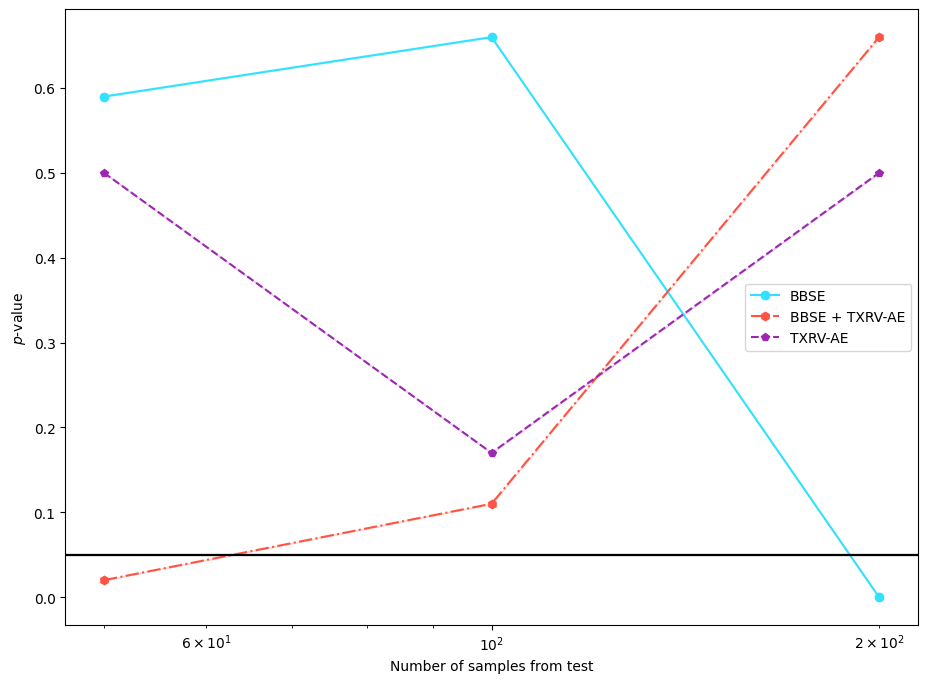

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.31 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.85 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.15 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.84 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.65 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.55 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.96 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.25 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.69 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.94 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.98 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.07 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.78 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.83 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.30 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.88 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.70 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.47 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.59 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.52 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.48 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.45 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.51 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.14 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.09 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.48 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.09 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.70 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.78 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.05 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.99 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.34 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.90 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.16 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.98 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.59 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.60 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.90 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.81 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.70 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.51 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.09 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.32 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.76 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.54 examples/s]

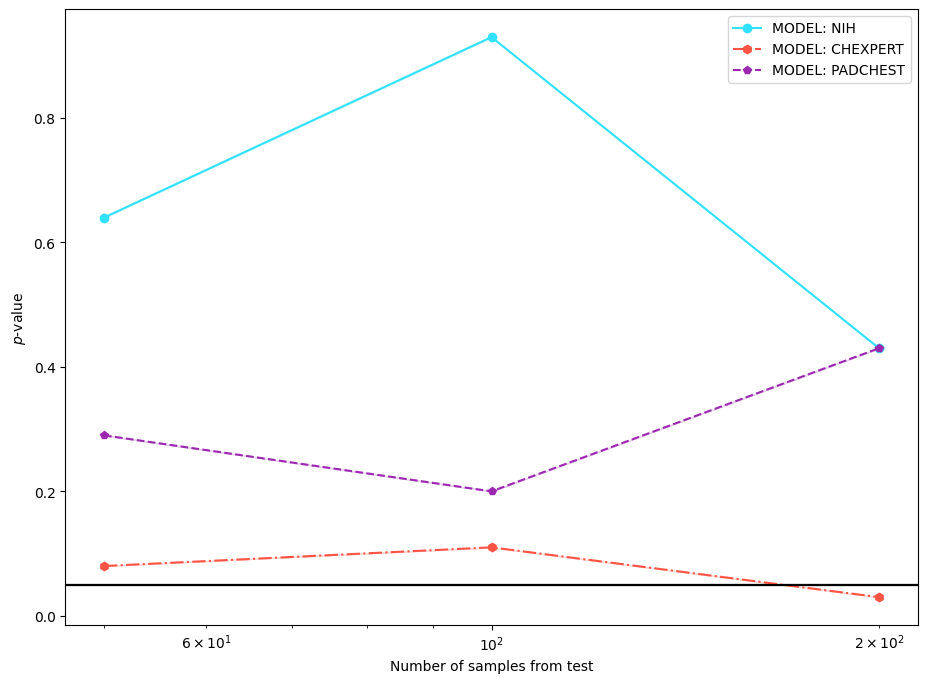

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52171.81 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77456.42 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91754.24 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100753.46 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106865.94 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108257.39 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 45129.44 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 64332.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 80214.24 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90354.87 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 105538.19 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110943.07 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.54 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.13 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.42 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.18 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.59 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.60 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.73 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.75 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.71 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.48 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.74 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.33 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.63 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.70 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52831.43 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71660.50 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85224.20 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94707.05 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 109880.44 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 122361.35 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48605.84 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72008.52 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89828.44 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98716.18 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101693.92 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110551.32 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.56 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.13 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.16 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.42 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.02 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.84 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.69 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.03 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.38 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.87 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.30 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.74 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.13 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53922.14 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72900.26 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88631.32 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103996.43 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 116887.48 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 127740.04 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47397.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70908.35 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83754.12 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94846.02 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102397.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108854.06 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.88 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.17 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.55 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.86 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.06 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.50 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.00 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.41 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.06 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.46 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.43 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.35 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.11 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54825.37 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77030.00 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90668.16 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99460.13 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105325.48 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109122.25 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52035.17 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73340.42 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87905.69 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97697.69 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104451.61 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111788.20 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.51 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.03 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.80 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.68 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.72 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.77 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.64 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.59 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.09 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.84 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.11 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.84 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.14 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.18 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.29 examples/s]

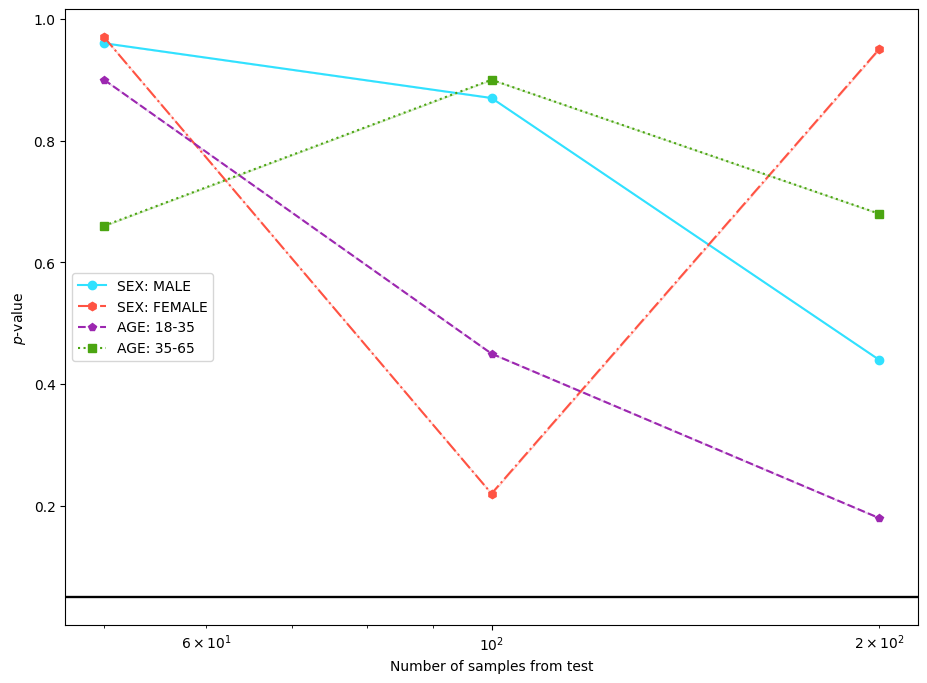

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.84 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.04 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.81 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.08 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.24 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.24 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.29 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.47 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.95 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.18 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.15 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.56 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.37 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.00 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.46 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.56 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.05 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.53 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.24 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.89 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.21 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.90 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.18 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.00 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.17 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.36 examples/s]

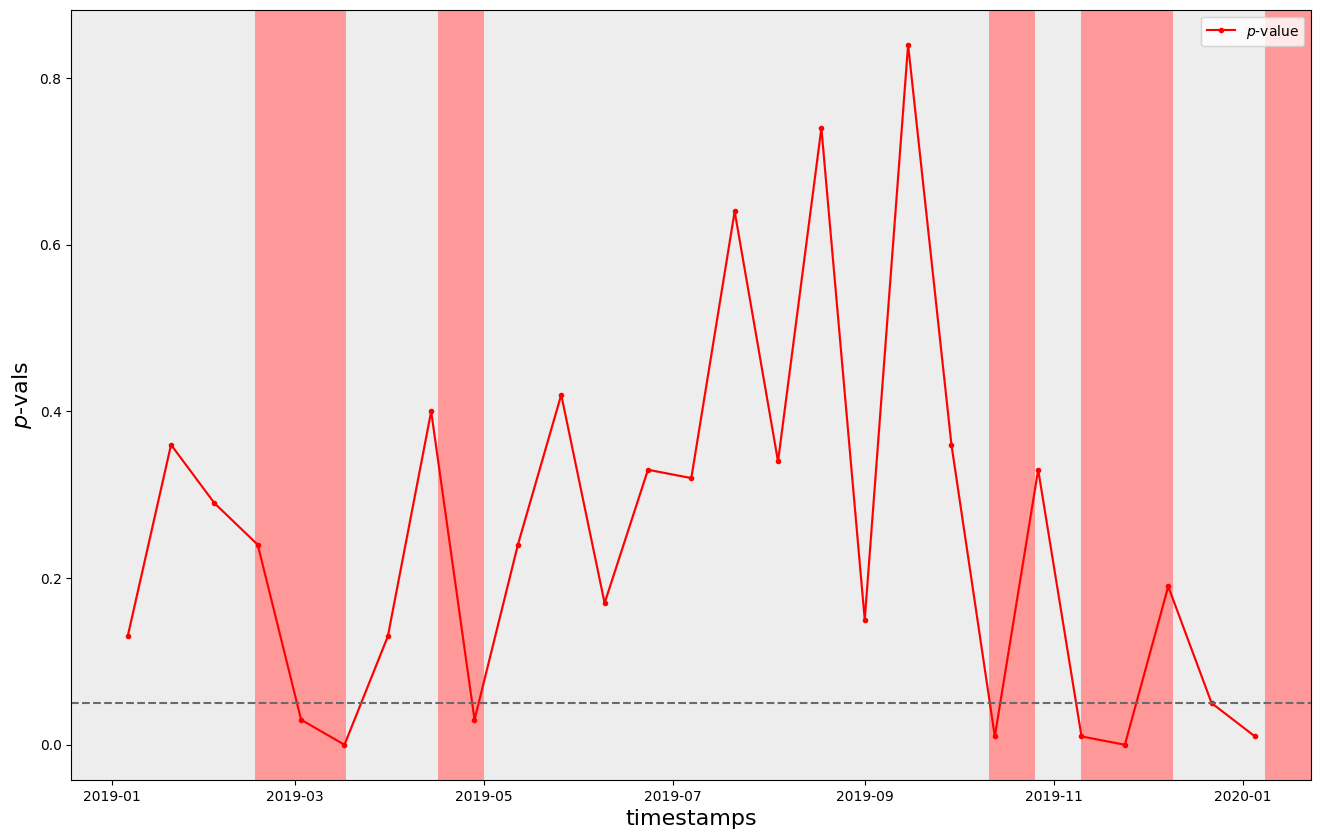

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)